# Simple Logistic Regression

Simple example for comparison of SLANG and Full-Gaussian VOGN models. We use australian scaled dataset. 

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cpu')

In [4]:
from slang.models import LogisticRegression, LogisticRegressionFull
from slang.train import *

- do_full_model: set false if you want only SLANG
- task: you have only one option here :)
- batch_size: 
- n_epoch: number of epochs to train
- beta: learning rate for $\Sigma$
- alpha: learning rate for $\mu$
- lambda: precision of the prior distribution
- rank: maximum rank of SLANG updates
- n_iter: number of orthogonalization iterates used for fast eigenvalues algorithm
- pow: learning rate decay for both alpha and beta
- n_samples_train: number of w samples for gradient during training
- n_samples_eval: number of w samples for gradient during evaluation

In [26]:
params = {"do_full_model": True,
          "task": "australian",
          "batch_size": 64,
          "n_epoch": 1000,
          "beta": 0.01,
          "alpha": 0.01,
          "lambda": 1,
          "rank": 5,
          "n_iter": 4,
          "pow": 0.2,
          "n_samples_train": 12,
          "n_samples_eval": 100
         }

Loading data:

In [27]:
if params["task"] == "australian":
    src = 'data/australian_presplit/australian_scale_'
    
print("Sorry, I can do only australian for now")
    
X_train = pd.read_csv(src + 'X_tr.csv', delim_whitespace=True)
y_train = pd.read_csv(src + 'y_tr.csv', delim_whitespace=True)
X_test = pd.read_csv(src + 'X_te.csv', delim_whitespace=True)
y_test = pd.read_csv(src + 'y_te.csv', delim_whitespace=True)

In [28]:
X = torch.tensor(X_train.values, dtype = torch.float)
X = torch.cat([X, torch.ones(X.shape[0], 1, dtype = torch.float)], dim = -1)
y = torch.tensor(y_train.values, dtype = torch.float).view(-1)
y[y == 0] = -1
params["N"] = X.shape[0]
    
X_test = torch.tensor(X_test.values, dtype = torch.float)
X_test = torch.cat([X_test, torch.ones(X.shape[0], 1, dtype = torch.float)], dim = -1)
y_test = torch.tensor(y_test.values, dtype = torch.float).view(-1)
y_test[y_test == 0] = -1

Train models:

In [29]:
model = LogisticRegression(X.shape[1], max_rank = params["rank"])
loss, test_nll = train(model, X, y, params, X_test, y_test)
covar = model.U @ model.U.t() + torch.diag(model.d)
final_nll = model.nll_loss(X_test, y_test, 
                           require_grads = False, 
                           n_samples = 2000).item()
    
if params["do_full_model"]:
    full_model = LogisticRegressionFull(X.shape[1])
    loss_f, test_nll_f = train(full_model, X, y, params, X_test, y_test)
    covar_f = torch.inverse(full_model.Sigma)
    final_nll_f = full_model.nll_loss(X_test, y_test, 
                                      require_grads = False, 
                                      n_samples = 2000).item()

Let's look at the final test negative log-likelihood

In [30]:
print("SLANG-{} test NLL:{}".format(params["rank"], final_nll))
if params["do_full_model"]:
    print("Full-Gaussian test NLL:{}".format(final_nll_f))

SLANG-5 test NLL:0.422284334897995
Full-Gaussian test NLL:0.37969428300857544


Validation loss to check if models have converged:

Text(0.5, 1.0, 'Test NLL')

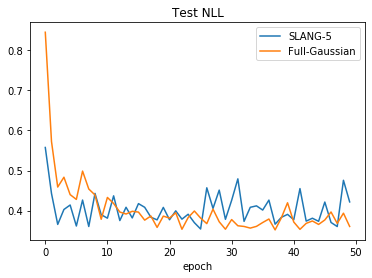

In [35]:
plt.plot(test_nll, label = "SLANG-{}".format(params["rank"]))
if params["do_full_model"]:
    plt.plot(test_nll_f, label = "Full-Gaussian")
plt.legend()
plt.xlabel('epoch')
plt.title("Test NLL")

And inverse covariance matrix that we found:

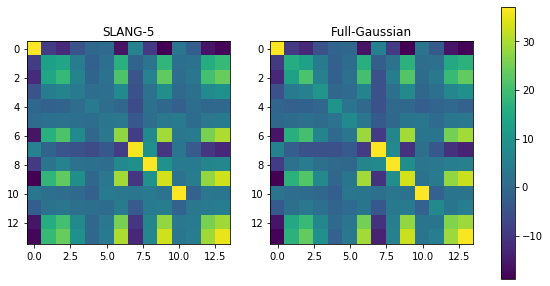

In [32]:
if params["do_full_model"]:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    titles = ["SLANG-{}".format(params["rank"]), "Full-Gaussian"]
    covars = [covar, covar_f]
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(covars[i].detach()[:X.shape[1] - 1, :X.shape[1] - 1])
        ax.set_title(titles[i])

    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

else:
    plt.imshow(covar[:X.shape[1] - 1, :X.shape[1] - 1])
    plt.colorbar()
    plt.show()